In [25]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import seaborn as sns
import numpy as np
import cv2
import os
# import required libraries

In [2]:
def load_images(superpath: str) -> tuple:
  imgs, labels, folders, label = [], [], [], 0
  for folder in os.listdir(superpath):
    if os.path.isdir(os.path.join(superpath, folder)):
      for image in os.listdir(os.path.join(superpath, folder)):
        try:
          img = cv2.imread(os.path.join(superpath, folder, image), 0)
          if img is not None: # is the image corrupt?
            img = cv2.resize(img, (80, 60)) # resize images to 80 x 80
            labels.append(label)
            imgs.append(img)
        except Exception as e:
          print(f"Error: {e}. Skipping file...")
      folders.append(folder)
      label += 1
  print(f"Folders were labeled from 0 to {label-1} in the following order: {folders}")
  return np.array(imgs), np.array(labels)

In [3]:
def process_images(x_train: np.ndarray, y_train: np.ndarray) -> tuple:
  x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1)
  x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.25) # split to validation set
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1) / 255.0
  x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1) / 255.0 # divide everything by 255
  x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1) / 255.0
  y_train, y_test, y_val = keras.utils.to_categorical(y_train), keras.utils.to_categorical(y_test), keras.utils.to_categorical(y_val)
  # convert labels to binary matrix
  return x_train, x_test, x_val, y_train, y_test, y_val

In [4]:
x_train, y_train = load_images(f'{os.environ["HOME"]}/Desktop/Dev/datasets/catsvsdogs') # my home path has a long name, so I prefer to use home env variable
x_train, x_test, x_val, y_train, y_test, y_val = process_images(x_train, y_train)

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Folders were labeled from 0 to 1 in the following order: ['Cat', 'Dog']


In [5]:
print(x_train.shape, x_test.shape, x_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(22451, 80, 80, 1) (1871, 80, 80, 1) (624, 80, 80, 1)
(22451, 2) (1871, 2) (624, 2)


In [77]:
model = keras.Sequential([
                          keras.layers.InputLayer(input_shape=(80, 80, 1)),

                          keras.layers.Conv2D(32, (5,5), padding='same', kernel_initializer='he_uniform'),
                          keras.layers.MaxPool2D((2,2)),
                          keras.layers.BatchNormalization(),
                          keras.layers.Activation('relu'),
                          keras.layers.Dropout(0.2),         

                          keras.layers.Conv2D(64, (5,5), padding='same', kernel_initializer='he_uniform'),
                          keras.layers.MaxPool2D((2,2)),
                          keras.layers.BatchNormalization(),
                          keras.layers.Activation('relu'),
                          keras.layers.Dropout(0.2),     

                          keras.layers.Flatten(), 

                          keras.layers.Dense(128, kernel_initializer='he_uniform'),
                          keras.layers.BatchNormalization(),
                          keras.layers.Activation('relu'),
                          keras.layers.Dropout(0.2),

                          keras.layers.Dense(2),
                          keras.layers.Activation('softmax')

])

In [78]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 80, 80, 32)        832       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 40, 40, 32)        0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 40, 40, 32)        128       
_________________________________________________________________
activation_63 (Activation)   (None, 40, 40, 32)        0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 40, 40, 64)        51264     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 20, 20, 64)      

In [79]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
lr_modifier = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, factor=0.1)

In [81]:
data = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_val, y_val), callbacks=[lr_modifier])

Epoch 1/5
351/351 [==============================] - 142s 402ms/step - loss: 0.5905 - accuracy: 0.6977 - val_loss: 0.6871 - val_accuracy: 0.6266
Epoch 2/5
351/351 [==============================] - 168s 478ms/step - loss: 0.4494 - accuracy: 0.7899 - val_loss: 0.4504 - val_accuracy: 0.7788
Epoch 3/5
351/351 [==============================] - 216s 615ms/step - loss: 0.3768 - accuracy: 0.8312 - val_loss: 0.4524 - val_accuracy: 0.8077
Epoch 4/5
351/351 [==============================] - 208s 593ms/step - loss: 0.2758 - accuracy: 0.8878 - val_loss: 0.4190 - val_accuracy: 0.8141
Epoch 5/5
351/351 [==============================] - 228s 650ms/step - loss: 0.2486 - accuracy: 0.9010 - val_loss: 0.4231 - val_accuracy: 0.8109


In [82]:
model.evaluate(x_test, y_test)

59/59 [==============================] - 3s 50ms/step - loss: 0.4145 - accuracy: 0.8156


[0.4144960939884186, 0.8156066536903381]

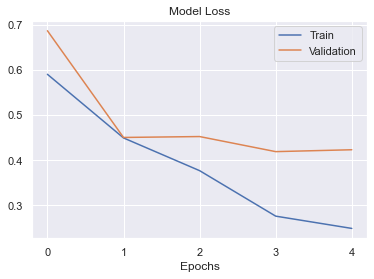

In [83]:
sns.set()
plt.yticks(np.arange(0, 2, 0.1))
plt.xticks(np.arange(0, 5, 1))
plt.xlabel("Epochs")
plt.title("Model Loss")
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.legend(['Train', 'Validation'], loc='upper right')

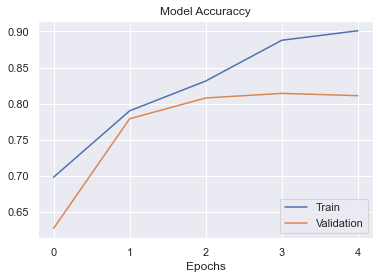

In [84]:
plt.xticks(np.arange(0, 5, 1))
plt.yticks(np.arange(0.3, 1, 0.05))
plt.xlabel("Epochs")
plt.title("Model Accuraccy")
plt.plot(data.history['accuracy'])
plt.plot(data.history['val_accuracy'])
plt.legend(['Train', 'Validation'], loc='lower right')

In [86]:
model.save("cats_and_dogs_1.h5")